In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('img/style.mplstyle')


def remove_failure(df):
    success = np.array(df['success'])
    print(np.sum(success) / len(df))
    return df[df['success']]


def read_simulations(extra):
    q = []
    for i in range(10):
        df = pd.read_csv('data/sim_'+str(i)+'_0'+extra+'.csv').sort_values('logB', ascending=False)
        df = remove_failure(df)
        q.append(np.array(df['logB']))
    
    # because of failure removal, not all arrays have the same length, let's enforce that
    lenn = np.min([len(qq) for qq in q])
    q = np.array([qq[:lenn] for qq in q])

    return np.sort(q, axis = 0)


In [3]:
scratch_base = '/pscratch/sd/j/jrobnik/'
scratch = scratch_base + 'quasars_scratch/'
dir_data = scratch_base + 'quasars/'
dir_results = 'data/'

ids = np.load(dir_data + 'ids.npy')

data = pd.read_csv('data/real_0_0.csv').sort_values('logB', ascending=False)
#data['log_post_odds'] = data['logB'] + data['log_prior_odds']
data1 = pd.read_csv('data/real_1002_0.csv').sort_values('logB', ascending=False)
#data1['log_post_odds'] = data1['logB'] + data1['log_prior_odds']

data_sim = read_simulations('')
#data_sim2 = read_simulations('_2tausim')

#data2 = pd.read_csv('data/real_2_0.csv').sort_valuessort_values('logB', ascending=False)

data = remove_failure(data)
data1 = remove_failure(data1)

info = pd.read_csv(dir_data + 'quasar_info.txt', delim_whitespace=True)
data = pd.merge(data, info, on= 'id')

0.9881298928864144
0.9879603199276489
0.9892886414379787
0.9884973009637397
0.9892321171183902
0.9876494361699121
0.9891473306390074
0.9879603199276489
0.9886951360822994
0.9879320577678546
0.9882712036853857
0.8418166916315745


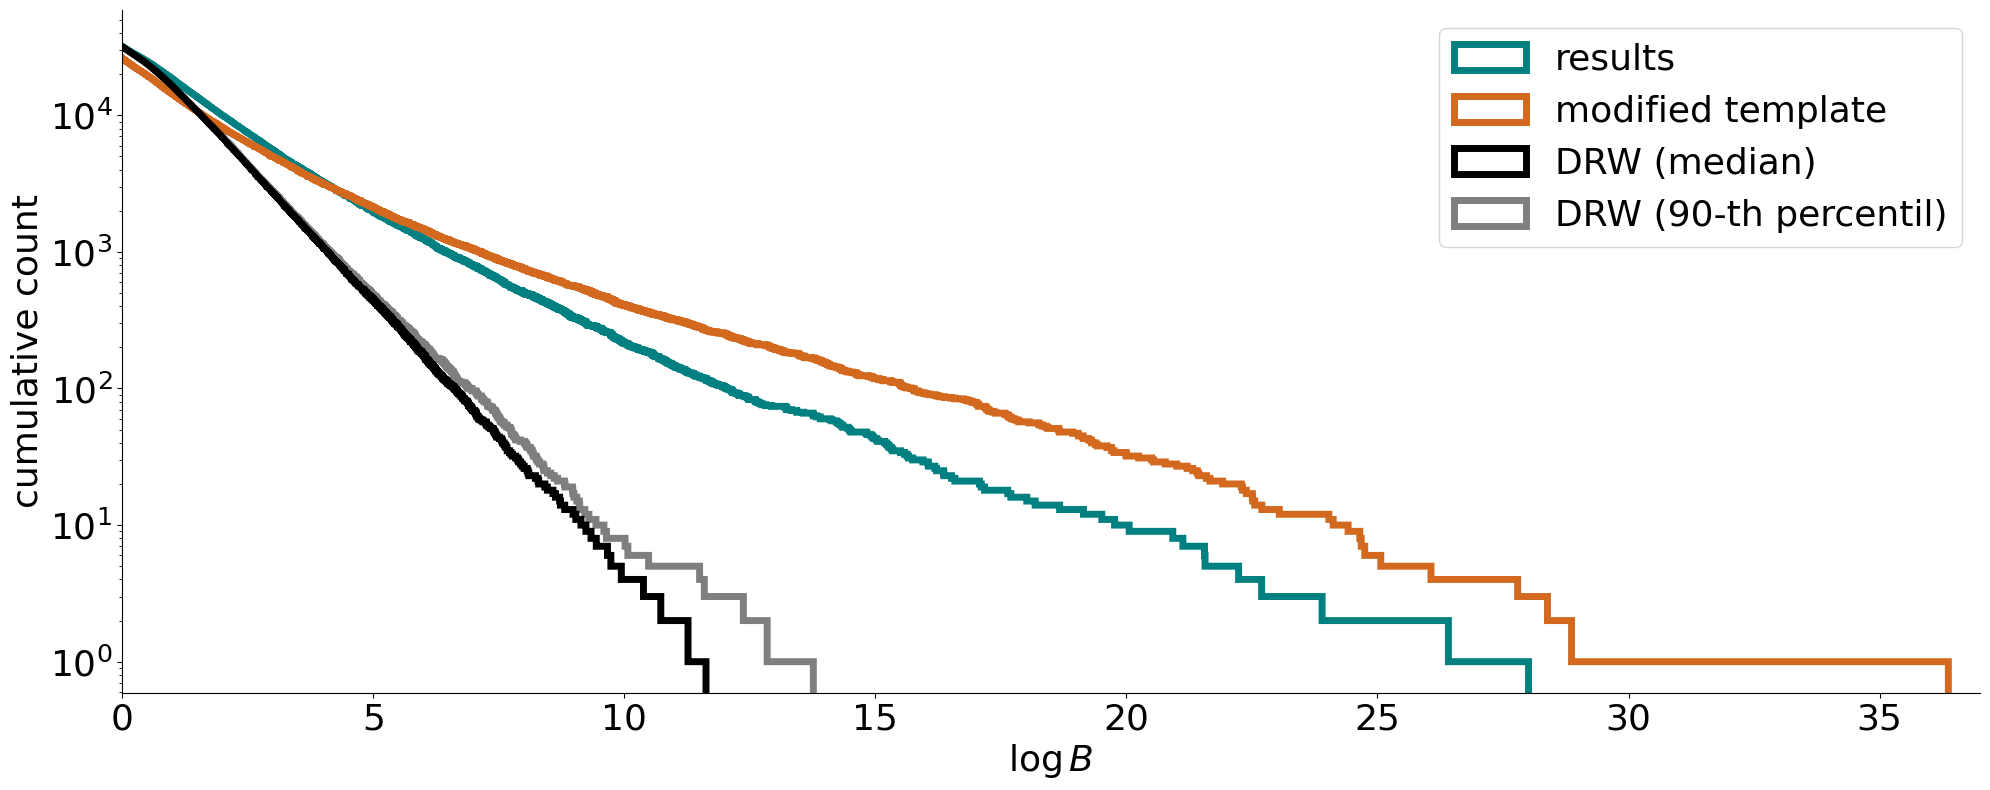

In [9]:
plt.figure(figsize= (20, 8))
ff = 26
plt.yticks(fontsize=ff)
plt.xticks(fontsize=ff)

istat = 1
stat = ['log_post_odds', 'logB', 'log_lik_ratio'][istat]
xlabel = [r'$\log \frac{P(H_1 \vert \mathrm{data})}{P(H_0 \vert \mathrm{data})}$', r'$\log B$', 'log-likelihood ratio'][istat]  
save_name = 'img/results' + ['_post_odds', '', '_loglik'][istat]  

X = [('results', 'teal', 1, np.array(data[stat]) ), 
     ('modified template', 'chocolate', 1, np.array(data1[stat]) ), 
     ('DRW (median)', 'black', 1, np.median(data_sim, axis= 0) ), 
     ('DRW (90-th percentil)', 'black', 0.5, data_sim[-1]),
     #('DRW2 (median)', 'tab:purple', 1, np.median(data_sim2, axis= 0) ), 
     #('DRW2 (90-th percentil)', 'tab:purple', 0.5, data_sim2[-1])
     ]


for name, color, alpha, x in X:
    x  = x[np.isfinite(x)]
    plt.hist(x, cumulative= -1, histtype= 'step', bins = len(x), label= name, lw= 5, color = color, alpha= alpha)

plt.xlim(0, 37)
plt.legend(fontsize= ff)
plt.xlabel(xlabel, fontsize = ff)
plt.ylabel('cumulative count', fontsize= ff)
plt.yscale('log')
plt.tight_layout()
plt.savefig(save_name)
plt.show()

366226
138084
263798
288754
316958
224111
304690
295361
294564
264967


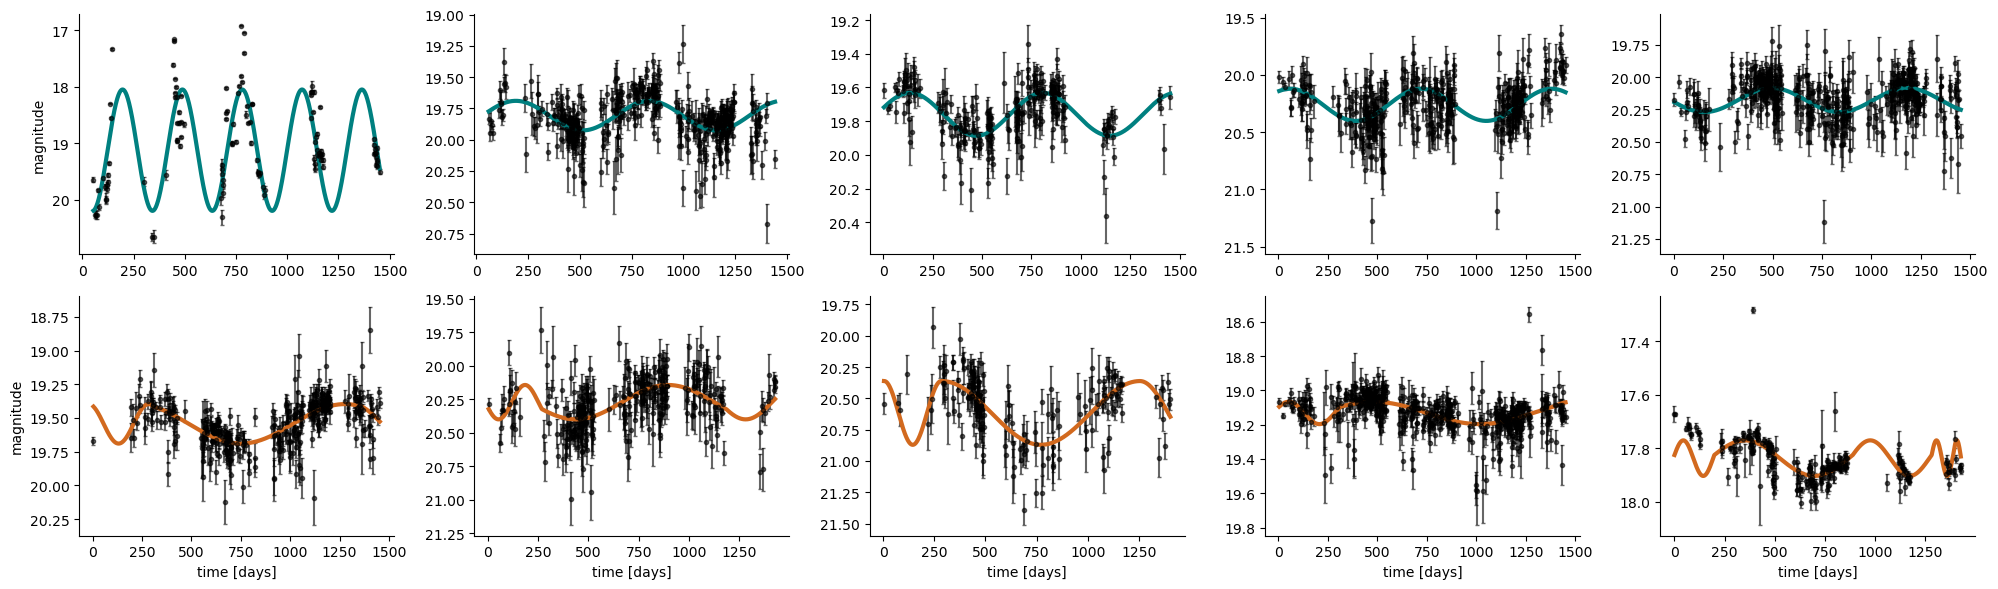

In [7]:
import jax
import jax.numpy as jnp

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True) # since we are on cpu we do not mind using 64 bits

from LombScargle import periodogram
from quasars.prep import load_data


def get_temp(temp_num, id):
    if temp_num == 0:
        return periodogram.basic
    else:
        job_id = jnp.argmin(jnp.abs(ids - id))
        key= jax.random.split(jax.random.key(42), 10 * len(ids)).reshape(10, len(ids))[temp_num][job_id]
        return periodogram.null_signal_template(key, 2000)


def plot_fit(results, temp_num):

    amp = np.array(results[['A_const', 'A_sin', 'A_cos']])
    freq_best = 1./results['period']
    id = results['id']
    time, mag, mag_err, _ = load_data(id)
    t0 = 54903.
    quasar_names = {366226: 'SDSS J162542.15+411841.0', 263798: 'SDSS J131232.14+470135.6', 316958: 'SDSS J143930.07+490025.1', 304690: 'SDSS J141922.98+534135.8', 294564: 'SDSS J140206.50+535618.5', 264967: 'SDSS J131426.16+372034.0', 263798: 'SDSS J131232.14+470135.6', 295399: 'SDSS J140337.06+551251.3', 294940: 'SDSS J140247.03+542654.9', 316958: 'SDSS J143930.07+490025.1'}
    print(id)
    #plt.title(quasar_names[id], y = 0.95)
    plt.errorbar(time-t0, mag, mag_err, fmt = '.', capsize = 1.3, alpha = 0.6, color= 'black', label= 'data')
    t = jnp.linspace(jnp.min(time), jnp.max(time), 1000)
    
    model = periodogram.fit(t, freq_best, amp, temp_func= get_temp(temp_num, id))
    plt.plot(t-t0, model, color = ['teal', 'chocolate', 'chocolate'][temp_num], lw = 3, label= 'model')
    plt.gca().invert_yaxis()

plt.figure(figsize = (20, 6))
    
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plot_fit(data.iloc[i], temp_num= 0)
    if i == 0:
        plt.ylabel('magnitude')
    plt.subplot(2, 5, i + 6)
    plot_fit(data1.iloc[i], temp_num= 1)
    plt.xlabel('time [days]')
    if i == 0:
        plt.ylabel('magnitude')
    
plt.tight_layout()
plt.savefig('img/candidates.png')
plt.show()

In [ ]:
 264967: 'SDSS J131426.16+372034.0', 263798: 'SDSS J131232.14+470135.6', 295399: 'SDSS J140337.06+551251.3', 294940: 'SDSS J140247.03+542654.9', 316958: 'SDSS J143930.07+490025.1'}


138084
288754
224111
295361
264967

701.2535100000023 198


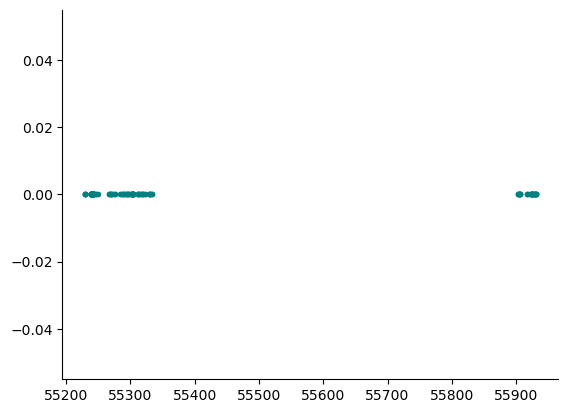

In [15]:
dir_data = '/pscratch/sd/j/jrobnik/quasars/'
id = np.load(dir_data + 'ids.npy')[14]
df = pd.read_csv(dir_data + str(id) + '.csv')
time = np.array(df['time'])
T = np.max(time) - np.min(time)
print(T, len(time))

plt.plot(time, np.zeros(len(time)), '.')
plt.show()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


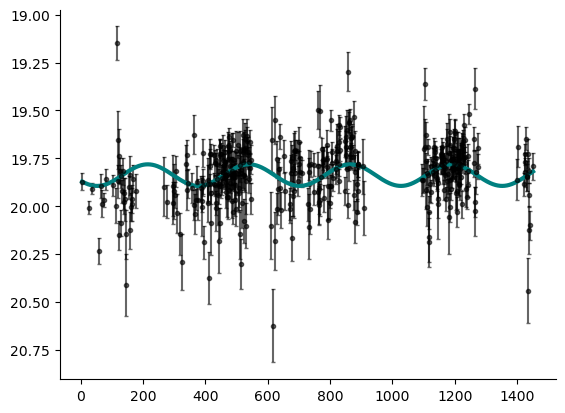

In [4]:
plot_fit(data[data['id'] == 304633].iloc[0], 0)

In [4]:
info = pd.merge(info, data[['id', 'log_prior_odds']], on= 'id')

In [7]:
info.to_csv(dir_data + 'quasar_info.csv')

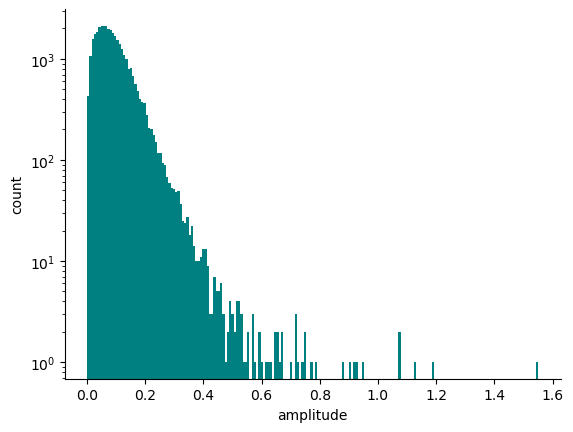

In [8]:
A = np.sqrt(np.square(data['A_cos']) + np.square(data['A_sin']))
plt.hist(A, bins = 200)
plt.yscale('log')
plt.xlabel('amplitude')
plt.ylabel('count')
plt.show()

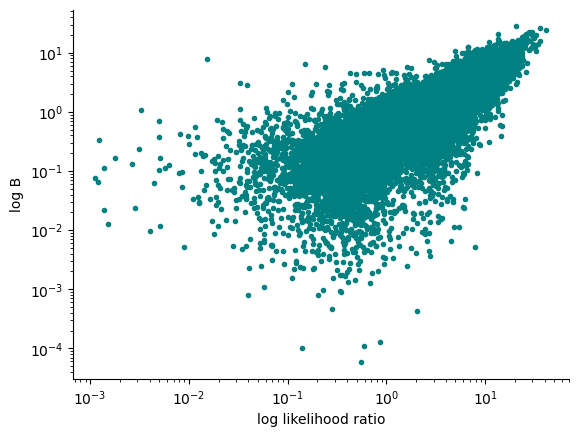

In [16]:
mask = np.isfinite(data['logB']) & (data['logB'] > 0.) #& (data['log_lik_ratio'] > 0.)
plt.plot(np.array(data['log_lik_ratio'])[mask], np.array(data['logB'])[mask], '.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log likelihood ratio')
#plt.xlim(1e-3, 100.)
plt.ylabel('log B')

plt.show()

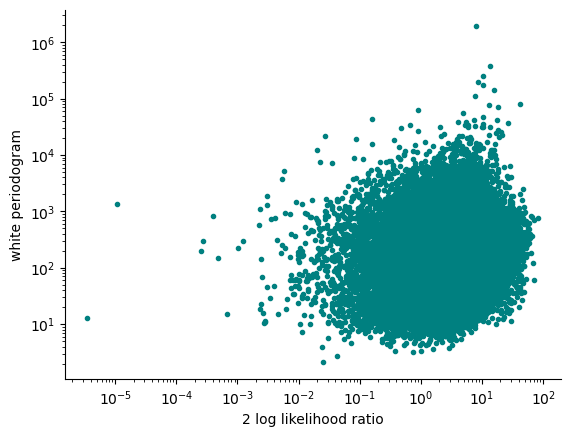

In [11]:
plt.plot(2 * np.array(data['log_lik_ratio']), np.array(data['white_periodogram']), '.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('2 log likelihood ratio')
plt.ylabel('white periodogram')
plt.show()

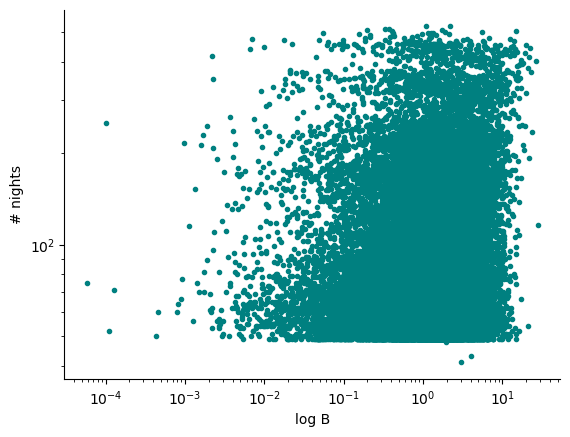

In [15]:
plt.plot(np.array(data['logB']), np.array(data['data_points']), '.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log B')
plt.ylabel('# nights')
plt.show()

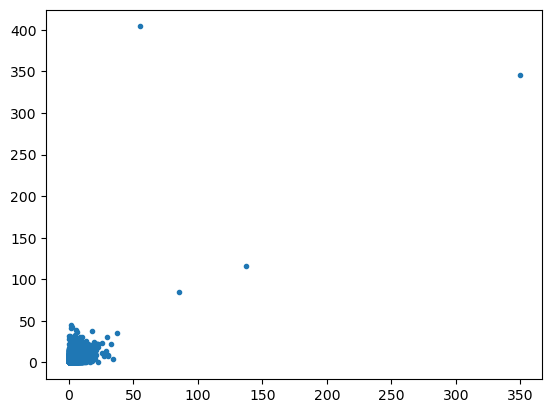

In [4]:
# are the same quasars detected on null and periodic?

data_both = data.merge(data2, on= 'id')
mask = np.isfinite(data_both['logB_x']) & np.isfinite(data_both['logB_y']) & (data_both['logB_x'] > 0) & (data_both['logB_y'] > 0)
plt.plot(np.array(data_both['logB_x'])[mask], np.array(data_both['logB_y'])[mask], '.')